# Shock Response Spectrum

The goal is to generate a shock response spectrum (SRS), given an input base acceleration-time data.

An SRS is a useful tool for estimating the damage potential of a shock pulse to some structure, as well as for test level specification.

In [1]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt

In [2]:
d = 0.011
h = 0.0001                      # timestep, h
t = np.arange(0, 0.05, h)       # time series, t
u = 70*np.sin(pi/d*t)*(t<=d)    # input acceleration, u (half-sine pulse of d seconds)

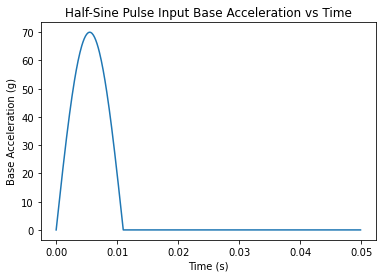

In [3]:
plt.plot(t, u)
plt.title("Half-Sine Pulse Input Base Acceleration vs Time")
plt.xlabel("Time (s)");
plt.ylabel("Base Acceleration (g)");
plt.show()

# SRS Calculation

The SRS is specifically a plot of the peak absolute accelerations of a structure against a range of hypothetical natural frequencies of interest. This gives us a the approximate worst case accelerations experienced by the structure.

We will first model the system as a Single-Degree-Of-Freedon Spring-Mass-Damnper system. We can derive a 2nd order ODE as follows.

$$\ddot{z} + 2\zeta\omega_0\dot{z} + \omega_0^2z = -\ddot{u}$$

The damping ratio $\zeta$ is given by the equation $\frac{1}{2Q}$, where $Q$ is set to $10$ for large metallic bodies in SRS calculations by convention. $z$ ans $u$ are the relative displacement of the structure to the base and the base displacement respectively. 

The absolute acceleration $\ddot{x}$ of the structure is given by the following relation.

$$\ddot{x} = \ddot{z} + \ddot{u}$$

First we find $z(t)$ by solving the 2nd order ODE with numerical methods, as we only have pairwise values of $\ddot{u}$ and $t$.

The method chosen to for the numerical integration is Runga Kutta's 4th Order Method (RK4). Given the initial value problem as such;

$$\frac{dy}{dx} = f(t, y), y(t_0) = y_0$$

We can solve for successive y values by the following;

\begin{equation}
\begin{split}
& y_{n+1} = y_n + \frac{1}{6}h(k_1 + 2k_2 + 2k_3 + k4) \\
& t_{n+1} = t_n + h
\end{split}
\end{equation}

Where $h$ is the timestep and,

\begin{equation}
\begin{split}
& k_1 = f(t_n, y_n) \\
& k_2 = f(t_n + \frac{h}{2}, y_nh\frac{k1}{2}) \\
& k_3 = f(t_n + \frac{h}{2}, y_nh\frac{k2}{2}) \\
& k_4 = f(t_n + h, y_n + hk3)
\end{split}
\end{equation}

RK4 is a much more accurate numerical integration method as compared to the famouse Euler's Method. However, RK4 can only be used to solve 1st order ODEs. We need to first transform our 2nd order ODE into a form we can work with.

State-Space Representation are mathematical models of physical systems as a set of input, output and state variables related by 1st order differentials.

We let $z_1 = z$ and $z_2 = \dot{z}$ be the the relative displacement and relative velocities, they are the minimum number of states required to quantify the 2nd order ODE. We then represent the dynamics (derivatives) of these states in terms of the states themselves, as well as the input $\ddot{u}$.

\begin{equation}
\begin{split}
& \dot{z_1} = z_2 \\
& \dot{z_2} = -2\zeta\omega_0\dot{z} - \omega_0^2z -\ddot{u}
\end{split}
\end{equation}

The State-Space Model can be represented in matrix form.

$$
\begin{bmatrix} \dot{z_1} \\ \dot{z_2} \end{bmatrix}
=
\begin{bmatrix} 0 & 1 \\ -\omega_0^2 & -2\zeta\omega_0 \end{bmatrix}
\begin{bmatrix} z_1 \\ z_2 \end{bmatrix}
+
\begin{bmatrix} 0 \\ -1 \end{bmatrix}\ddot{u}
$$

Define $y = \begin{bmatrix} z_1 \\ z_2 \end{bmatrix} $, we can get that our state-space model follows $\dot{y} = Ay + B\ddot{u}$, the exact form we are able to apply RK4 on. With initual conditions of $y_0$ being $\begin{bmatrix} 0 \\ 0 \end{bmatrix}$, seeing as how the displacements and velocities of both the base and structure is $0$. We can find $z$ by applying $z = \begin{bmatrix} 1 & 0 \end{bmatrix}y$.

Employing RK4 allows us to evaluate for pairwise values of $z$ and $t$. We're interested in finding $\ddot{x}(t).$ Going back to the equation $\ddot{x} = \ddot{z} + \ddot{u}$, we just need to find $\ddot{z}$ and add it to $\ddot{u}$. Again, we need to use a numerical method to find calculate the derivative. This would be done by taking successive differences between $z(i)$ and $z(i+1)$, keeping in mind that the the size of our $\dot{z}$ array would be $1$ less than the $z$ array. Repeating for the 2nd derivative, lastly, summing $\ddot{z}$ and $\ddot{u}$ gives us $\ddot{x}$. We can now store the maximum value of $\ddot{x}$ against the $\omega_0$ value used to calculate this absolute acceleration. We repeat this over the range of natural frequencies of interest. The resulting plot of the peak $\ddot{x}$ values against $\omega_0$ gives us the SRS.

A sample implementation of the above described algorithm is given below.


In [4]:
Q = 10
zeta = 1/(2*Q)

f1 = 10
f2 = 2000
w = 2*pi*f1
w2 = 2*pi*f2

dt = np.diff(t)
d2t = np.diff(t[0:len(t)-1])
d2udt2 = u[0:len(u)-2]

Hz = []
peak_acceleration = []

while (w<=w2):
    # State Space Representation Matrices
    A = np.array([[0, 1], [-w**2, -2*zeta*w]])
    B = np.array([[0], [-1]])
    C = np.array([1, 0])
    
    z = [0]
    y = np.array([[0], [0]])
    
    # Runga Kutta 4th Order Method
    for i in range(len(u)-1):
        k1 = h * (A.dot(y) + B*u[i])
        k2 = h * (A.dot(y+(k1/2)) + B*(u[i]+u[i+1])/2)
        k3 = h * (A.dot(y+(k2/2)) + B*(u[i]+u[i+1])/2)
        k4 = h * (A.dot(y+k3) + B*u[i+1])
        
        y = y + (k1 + 2*k2 + 2*k3 + k4)/6
        z.append(C.dot(y))
    
    # Numerical Double Differentiation
    dzdt = np.diff(z)/dt
    d2zdt2 = np.diff(dzdt)/d2t
    d2xdt2 = d2zdt2 + d2udt2
    
    Hz.append(w/(2*pi))
    peak_acceleration.append(np.amax(d2xdt2))
    w += 10

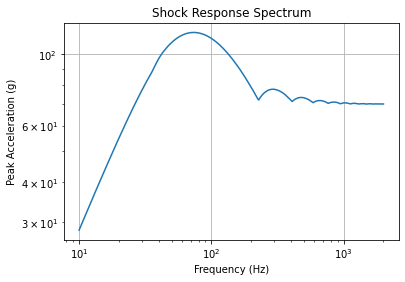

In [5]:
plt.plot(Hz, peak_acceleration)
plt.yscale("log")
plt.xscale("log")
plt.title("Shock Response Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Peak Acceleration (g)")
plt.grid()
plt.show()